In [1]:
import couler.argo as argo
from couler.core.templates.volume import Volume, VolumeMount
from couler.core.templates.volume_claim import VolumeClaimTemplate
from onepanel.couler import Submitter
import numpy as np

### Preprocessing

In [2]:
# Data augmentation function including dependency imports
# All functions used as source must not receive parameters, and not use global variables
# Make sure to import all required libraries inside the function
# Used paths must match with VolumeMounting paths
def augment_data_source():
    import tensorflow as tf
    import albumentations as A
    import numpy as np
    from tqdm import tqdm
    import os

    # Load CIFAR10 dataset
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Define transformations for Data Augmentation
    transform = A.Compose([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ])
    
    # Create output directories
    if not os.path.isdir('/mnt/output/train'):
        os.makedirs('/mnt/output/train')
        
    # Apply Data augmentation to images    
    transformed_images = np.zeros_like(x_train)
    
    for idx, image in enumerate(tqdm(x_train)):
        transformed = transform(image=image)
        transformed_image = transformed["image"]
        transformed_images[idx] = transformed_image
        
    # Save train(augmented) and test data as serialized numpy objects
    np.save('/mnt/output/train/x_train.npy', np.concatenate([x_train, transformed_images]))
    np.save('/mnt/output/train/y_train.npy', np.concatenate([y_train, y_train]))
    np.save('/mnt/output/train/x_test.npy', x_test)
    np.save('/mnt/output/train/y_test.npy', y_test)
        

In [3]:
# Test data augmentation function (source script)
augment_data_source()

170500096/170498071 [==============================] - 4s 0us/step


100%|██████████| 50000/50000 [00:04<00:00, 10947.02it/s]


In [4]:
# Load augmented train images
import matplotlib.pyplot as plt
augmented_images = np.load('/mnt/output/train/x_train.npy')
print(augmented_images.shape)

(100000, 32, 32, 3)


Text(0.5, 1.0, 'Augmented Image')

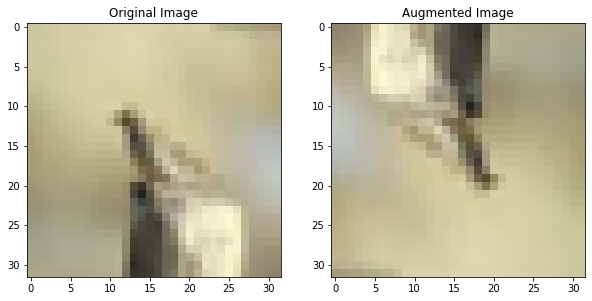

In [5]:
# Select random image to check augmentations
# Re-run this cell to pick a different sample
original_image_idx = np.random.randint(0, augmented_images.shape[0]//2)
augmented_image_idx = original_image_idx + augmented_images.shape[0]//2

# Plot original and augmented images side by side
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(augmented_images[original_image_idx])
axes[0].set_title('Original Image')
axes[1].imshow(augmented_images[augmented_image_idx])
axes[1].set_title('Augmented Image')

## Training

In [6]:
# Full training Workflow function, including dependency imports
def tensorflow_source():
    import os
    import json
    import numpy as np
    import tensorflow as tf
    from tqdm.keras import TqdmCallback

    # Load dataset from numpy serialized objects
    x_train = np.load('/mnt/output/train/x_train.npy')
    y_train = np.load('/mnt/output/train/y_train.npy')
    x_test = np.load('/mnt/output/train/x_test.npy')
    y_test = np.load('/mnt/output/train/y_test.npy')
    
    # Normalize inputs
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Model definition
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=124, activation='relu'),
        tf.keras.layers.Dropout(rate=0.75),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])
    
    # Optimizer definition
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Write TensorBoard logs to /mnt/output
    log_dir = '/mnt/output/tensorboard/'
    tqdm_callback = TqdmCallback()  # Tqdm progress bar works better with noTTY than defaul Keras progress bar
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Model training
    model.fit(x=x_train,
            y=y_train,
            epochs=1,
            validation_data=(x_test, y_test),
            callbacks=[tensorboard_callback, tqdm_callback],
            verbose=0)

    # Store metrics for this task
    loss, accuracy = model.evaluate(x_test, y_test)
    metrics = [
        {'name': 'accuracy', 'value': accuracy},
        {'name': 'loss', 'value': loss}
    ]
    with open('/tmp/sys-metrics.json', 'w') as f:
        json.dump(metrics, f)
        
    # Create output directories
    if not os.path.isdir('/mnt/output/model'):
        os.makedirs('/mnt/output/model')

    # Save model
    model.save('/mnt/output/model/model.h5')

In [ ]:
# Test training function(source script)
tensorflow_source()

In [19]:
submitter = Submitter(workflow_name='python-defined-dag')

INFO:root:Onepanel configuration detected
INFO:root:Initialized


In [20]:
def augment_data():
    output = argo.create_local_artifact(
        path='/mnt/output/train',
    )
    volume_claim_name = 'augmentation-output'
    pvc = VolumeClaimTemplate(volume_claim_name, size='20Gi') # Volume name must contain lowercase alphanumeric characters only
    volume_mount = VolumeMount(volume_claim_name, '/mnt/output/train') # Volume mounting points must be always different, name must match the volume claim
    argo.create_workflow_volume(pvc)    # VolumeClaims must be registered into the main workflow template
    argo.run_script(   # Couler run functions returns outputs
        image='onepanel/dl:0.17.0',
        command=['python', '-u'],
        source=augment_data_source,
        step_name='augment-data',
        node_selector={'node.kubernetes.io/instance-type': 'Standard_D4s_v3'},
        volume_mounts=[volume_mount],
        output=output
    )


def train_model():
    output = argo.create_local_artifact(
        path='/mnt/output/model',
    )
    volume_claim_name = 'training-output'
    pvc = VolumeClaimTemplate(volume_claim_name, size='20Gi')
    volume_mount = VolumeMount(volume_claim_name, '/mnt/output/model')
    argo.create_workflow_volume(pvc)
    argo.run_script(
        image='onepanel/dl:0.17.0',
        command=['python', '-u'],
        source=tensorflow_source,
        step_name='train-model',
        node_selector={'node.kubernetes.io/instance-type': 'Standard_D4s_v3'},
        volume_mounts=[volume_mount],
        output=output
    )

    
def dag():
    argo.set_dependencies(lambda: augment_data(), dependencies=None)
    argo.set_dependencies(lambda: train_model(), dependencies=['augment-data']) # Outputs from previous steps are used as parameter of the next step

In [21]:
argo._cleanup() # Required to clear global variables to run dag multiple times
dag() # Generate DAG

In [22]:
argo.run(submitter) # Execute Workflow

INFO:root:Workflow Template updated
INFO:root:Workflow Executed
